# Packages

In [49]:
#!pip3 install joblib numpy statsmodels scipy seaborn matplotlib

from tqdm import tqdm
import pandas as pd
import os 
import pandas as pd
import numpy as np
from joblib import Parallel, delayed
import numpy as np
import pandas as pd
from statsmodels.stats.contingency_tables import mcnemar
import matplotlib.pyplot as plt
import concurrent.futures
import seaborn as sns
import random 
from scipy.stats import norm


# Power Analysis

## Treatment Effect
- A laboratory experiment (Kaiser et al (2022)) asked users to imagine that somebody the participant followed posted misinformation. Then the study asked participant's to rate their intentions to unfollow that individual on a scale of 1-6, with 1 being unfollowing "does not at all apply" and 6 being "does fully apply". Summing the percentage of respondents who answered 4-6 is a rough measure of the percentage of respondent's who would be more likely than not to unfollow. That sum is ~19%.

- One study (Lin et al 2024) compared the effect size of accuracy nudges in the lab to the effect size of accurarcy nudges when used in a digital ad experiment similar to ours. We use this ratio to inform how much to discount Kaiser et al. (2022). From page 11, we use the lower bound of the ad efficacy (2.6%) and the upper bound of the lab estimate (10%) to arrive at a base discount factor of (1 - 2.6/10) 74%. Doing so would yield 26% of 19%  = 5%

## Control Rate
- Ashkinaze et al (2024) looked at the unfollowing rate of health misinformation spreaders and found it was 0.52% per month
- We perturn this amount by +- 20%

14 DAYS




Running Power Analysis:   0%|                                                                                    | 0/60 [00:00<?, ?it/s]

Running Power Analysis:  27%|████████████████████                                                       | 16/60 [00:00<00:01, 40.80it/s]

Running Power Analysis:  40%|██████████████████████████████                                             | 24/60 [00:01<00:02, 16.13it/s]

Running Power Analysis:  53%|████████████████████████████████████████                                   | 32/60 [00:02<00:02, 12.48it/s]

Running Power Analysis:  67%|██████████████████████████████████████████████████                         | 40/60 [00:03<00:01, 11.01it/s]

Running Power Analysis:  80%|████████████████████████████████████████████████████████████               | 48/60 [00:03<00:01, 10.30it/s]

Running Power Analysis: 100%|███████████████████████████████████████████████████████████████████████████| 60/60 [00:04<00:00, 12.33it/s]


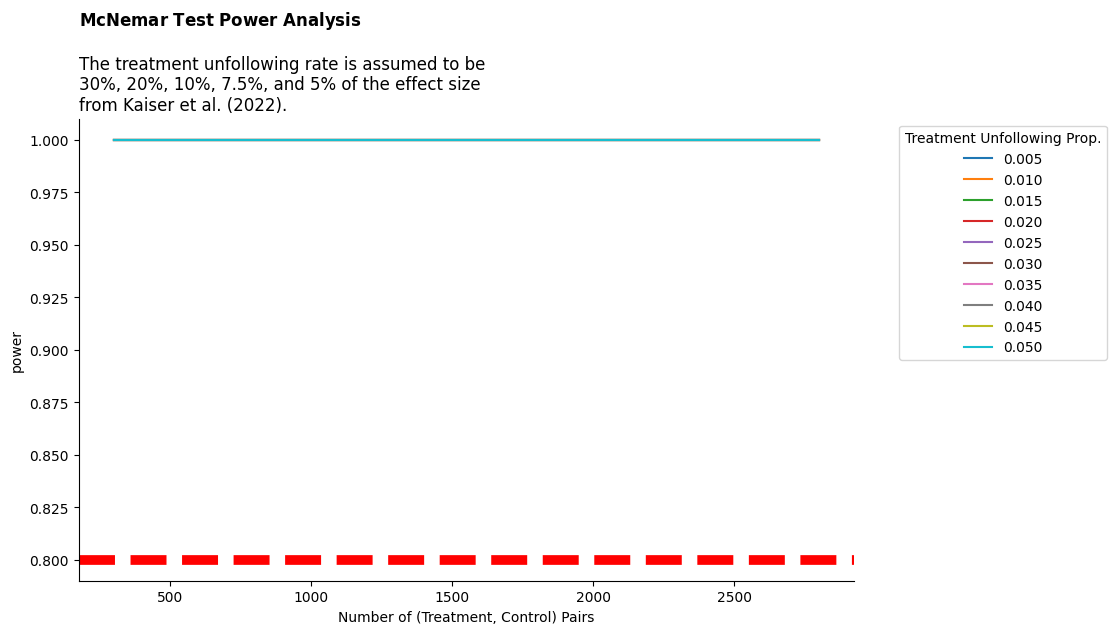

   treatment_prop    N treatment_prop_label
0           0.005  300                0.005
1           0.010  300                0.010
2           0.015  300                0.015
3           0.020  300                0.020
4           0.025  300                0.025
5           0.030  300                0.030
6           0.035  300                0.035
7           0.040  300                0.040
8           0.045  300                0.045
9           0.050  300                0.050


<Figure size 640x480 with 0 Axes>

In [69]:
np.random.seed(416)
random.seed(416)

#########################
#########################
# # Power Analysis

# ## Treatment Effect
# - A laboratory experiment (Kaiser et al (2022)) asked users to imagine that somebody the participant followed posted misinformation. Then the study asked participant's to rate their intentions to unfollow that individual on a scale of 1-6, with 1 being unfollowing "does not at all apply" and 6 being "does fully apply". Summing the percentage of respondents who answered 4-6 is a rough measure of the percentage of respondent's who would be more likely than not to unfollow. That sum is ~19%. We then 'discount' this effect size by different values

# - One study (Lin et al 2024) compared the effect size of accuracy nudges in the lab to the effect size of accurarcy nudges when used in a digital ad experiment similar to ours. We use this ratio to inform how much to discount Kaiser et al. (2022). From page 11, we use the lower bound of the ad efficacy (2.6%) and the upper bound of the lab estimate (10%) to arrive at a base discount factor of (1 - 2.6/10) 74%. That is, we assume the true effect of Kaiser et al (2022) will be roughly 26% of the lab effect. To simulate some uncertanity we randomly perturb the discount factor by +- 20%.

# ## Control Rate
# - Ashkinaze et al (2024) looked at the unfollowing rate of health misinformation spreaders and found it was 0.52% per month
# - We perturb this amount by +- 20%

#########################
#########################
# ASSUMPTIONS
#########################
#########################

# Constants 
NOISE = 0.2
N_MONTHS = 1

# Treatment assumptions
TREATMENT_FX = 0.19
BASE_TREATMENT_DISCOUNT = 1 - (2.6/10)
TREATMENT_DISCOUNT_RANGE = [(1-NOISE)*BASE_TREATMENT_DISCOUNT, (1+NOISE)*BASE_TREATMENT_DISCOUNT]

# Control assumptions
CONTROL_MONTHLY_UNFOLLOW = 0.0052
CONTROL_MONTHLY_UNFOLLOW_RANGE = [(1-NOISE)*CONTROL_MONTHLY_UNFOLLOW, (1+NOISE)*CONTROL_MONTHLY_UNFOLLOW]

def run_power_analysis(params, df):
    """Run power analysis and iterate over control_prop, treatment_prop, and N_values."""
    n_days_list = params['n_days']
    control_props = params['control_prop']
    treatment_props = params['treatment_prop']  
    N_values = params['N_values']
    n_simulations = params['n_simulations']
    treat_eligible = params['treat_eligible']

    all_records = []

    tasks = [(control_prop, treatment_prop, n_days, N)
             for control_prop in control_props
             for treatment_prop in treatment_props
             for n_days in n_days_list
             for N in N_values]

    def process_task(control_prop, treatment_prop, n_days, N):
        adj_control_prop = control_prop * (n_days / 30)
        power = estimate_power(df, N, adj_control_prop, treatment_prop, 0.05, n_simulations)
        return {'control_prop': control_prop, 'treatment_prop': treatment_prop, 'power': power, 'N': N}

    results = Parallel(n_jobs=-1)(delayed(process_task)(cp, tp, nd, N) for cp, tp, nd, N in tqdm(tasks, desc="Running Power Analysis"))

    df_results = pd.DataFrame(results)
    return df_results


def estimate_power(df, N, control_prop, treatment_prop, treat_eligible, alpha=0.05, n_simulations=100):
    """Estimate the power of the test, considering unequal sample sizes from 'df'."""
    # Calculate N_control and N_treatment based on 'treated' column
    df_sample = df.sample(N)
    N_control = df_sample[df_sample['treated'] == 0].shape[0]
    N_treatment = df_sample[df_sample['treated'] == 1].shape[0]
    N_effective_treatment = treat_eligible * N_treatment
    print(N_effective_treatment)
    
    significant_count = 0
    for _ in range(n_simulations):
        is_significant = run_simulation(N_control, N_effective_treatment, control_prop, treatment_prop, alpha)
        if is_significant:
            significant_count += 1
    return significant_count / n_simulations

def run_simulation(N_control, N_treatment, control_prop, treatment_prop, alpha):
    """Adjust to use N_control and N_treatment for z-test."""
    p_value = difference_in_proportions_test(N_control, N_treatment, control_prop, treatment_prop)
    return p_value <= alpha
    
def make_graph(df_results):
    df_results['treatment_prop_label'] = df_results['treatment_prop'].apply(lambda x: f"{x:.3f}")
    plt.figure(figsize=(10,6))
    title = r"$\bf{McNemar\ Test\ Power\ Analysis}$" + "\n\nThe treatment unfollowing rate is assumed to be\n30%, 20%, 10%, 7.5%, and 5% of the effect size\nfrom Kaiser et al. (2022)."
    plt.title(title, ha='left', x=0)
    sns.lineplot(data=df_results, x="N", y="power", hue="treatment_prop_label")
    plt.axhline(y=0.8, linestyle='dashed', color='red', linewidth=7)
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', title="Treatment Unfollowing Prop.")
    plt.xlabel("Number of (Treatment, Control) Pairs")
    sns.despine()
    plt.show()
    plt.savefig("power_analysis.png", dpi=400)

def find_required_N(df_results):
    """Find the N required to achieve 80% power for each treatment_prop."""
    df_filtered = df_results[df_results['power'] >= 0.8]
    df_required_N = df_filtered.groupby('treatment_prop', as_index=False)['N'].min()
    df_required_N['treatment_prop_label'] = df_required_N['treatment_prop'].apply(lambda x: f"{x:.3f}")
    return df_required_N



def difference_in_proportions_test(N_control, N_treatment, control_prop, treatment_prop):
    """
    Calculate z-statistic and p-value for the difference in proportions
    with unequal sample sizes using statsmodels.
    """
    # Convert proportions to the number of successes
    count = np.array([int(N_control * control_prop), int(N_treatment * treatment_prop)])
    # Define the sample sizes
    nobs = np.array([N_control, N_treatment])
    # Conduct the z-test
    z_stat, p_value = proportions_ztest(count, nobs)
    return p_value





print("14 DAYS")

df = pd.read_csv("treat_status_MINIMAL_FOLLOWERS_03.04.2024__17.11.03__START0_END-1.csv")
params = {
    'control_prop': [0.058],
    'treatment_prop': np.linspace(0.005, 0.05, 10),
    'N_values': range(300, 3000, 500),
    'n_days':[14],
    'n_simulations': 1000,
    "treat_eligible":[0.3]
}

df_results = run_power_analysis(params, df)
make_graph(df_results)
print(find_required_N(df_results))